## Trying out the AutoGP package for a QPO model

In this notebook, we wil be trying to fit and get the covaraince function for a simulated QPO dataset using the AutoGP package. 

The dataset is made by sampling from a GP using a Quasi Periodic +  Red Noise Kernel. 

$$
k_{qpo+rn}(\tau) = a_{qpo} \; exp(-c_{qpo} \tau) \; cos(2\pi f\tau) + a_{rn} \; exp(-c_{rn} \tau)
$$

We try to predict on the test and some future time points, and also try to use the package to get the covariance function.

#### Initial Conculsion:

While the method produces a kernel which fits the given data well, the extrapolation on this dataset has a high varaince. Also the covariance function learnt does have a similar shape, it does not learn the periodic behaviour and is of much lower magnitude than the kernel used to generate the data.

In [1]:
pwd()

"/Users/gaurav/Desktop/Open_Source/Learning_Stuff/julia/gpexp"

In [2]:
using Pkg
Pkg.activate("")

  Activating project at `~/Desktop/Open_Source/Learning_Stuff/julia/gpexp`


In [3]:
using CSV
import DataFrames
csv_file_path = "toy_qpo_dataset.csv"
data = CSV.File("toy_qpo_dataset.csv", header=[:counts, :times], types=Dict(:counts=>Float64, :times=>Float64));
df = DataFrames.DataFrame(data)
show(df) 

256×2 DataFrame
 Row │ counts     times      
     │ Float64    Float64    
─────┼───────────────────────
   1 │  2.47198   0.0
   2 │  2.72217   0.00392157
   3 │  2.32262   0.00784314
   4 │  2.67549   0.0117647
   5 │  2.36774   0.0156863
   6 │  1.97559   0.0196078
   7 │  1.1174    0.0235294
   8 │  0.669607  0.027451
  ⋮  │     ⋮          ⋮
 250 │  1.59012   0.976471
 251 │  1.28369   0.980392
 252 │  2.06542   0.984314
 253 │  1.68198   0.988235
 254 │  1.79613   0.992157
 255 │  2.28979   0.996078
 256 │  3.14118   1.0
             241 rows omitted

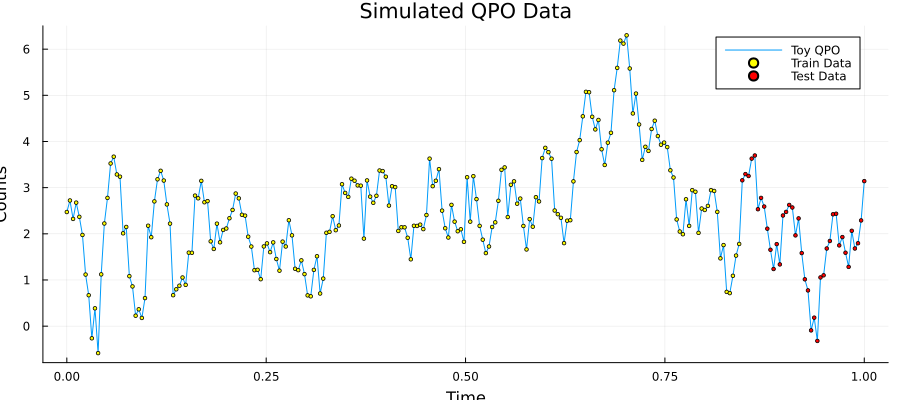

In [21]:
using Plots
n_test = 40
n_train = DataFrames.nrow(df) - n_test
df_train = df[1:end-n_test, :]
df_test = df[end-n_test+1:end, :]

# Creating the Plot for the data
plot(df.times, df.counts, label = "Toy QPO")
scatter!(df_train.times, df_train.counts, label="Train Data", color="yellow", markersize=2)
scatter!(df_test.times, df_test.counts, label="Test Data", color="red", markersize=2)
xlabel!("Time")
ylabel!("Counts")
title!("Simulated QPO Data")
plot!(size=(900, 400))

In [23]:
import AutoGP

┌ Warning: Module StatsBase with build ID fafbfcfd-eeeb-9b2a-0004-b2eb35c1db91 is missing from the cache.
│ This may mean StatsBase [2913bbd2-ae8a-5f71-8c99-4fb6c76f3a91] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1793
┌ Warning: Module StatsBase with build ID fafbfcfd-eeeb-9b2a-0004-b2eb35c1db91 is missing from the cache.
│ This may mean StatsBase [2913bbd2-ae8a-5f71-8c99-4fb6c76f3a91] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1793


┌ Warning: Module StatsBase with build ID fafbfcfd-eeeb-9b2a-0004-b2eb35c1db91 is missing from the cache.
│ This may mean StatsBase [2913bbd2-ae8a-5f71-8c99-4fb6c76f3a91] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1793


┌ Warning: Module Distributions with build ID ffffffff-ffff-ffff-0004-e5c9b1c946d3 is missing from the cache.
│ This may mean Distributions [31c24e10-a181-5473-b8eb-7969acd0382f] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1793


┌ Warning: Module Distributions with build ID ffffffff-ffff-ffff-0004-e5c9b1c946d3 is missing from the cache.
│ This may mean Distributions [31c24e10-a181-5473-b8eb-7969acd0382f] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1793


In [25]:
model = AutoGP.GPModel(df_train.times, df_train.counts; n_particles=6);

In [26]:
weights = AutoGP.particle_weights(model)
kernels = AutoGP.covariance_kernels(model)
for (i, (k, w)) in enumerate(zip(kernels, weights))
    println("Model $(i), Weight $(w)")
    Base.display(k)
end

LIN(0.16; 0.39, 0.70)


Model 1, Weight 6.45437028736887e-81


LIN(0.85; 0.04, 0.58)


×
├── ×
│   ├── LIN(0.13; 0.66, 0.21)
│   └── GE(0.04, 1.19; 0.02)
└── PER(0.36, 0.09; 0.18)


Model 2, Weight 0.09366058842974041
Model 3, Weight 1.526147823341734e-107


×
├── GE(0.09, 0.80; 0.67)
└── ＋
    ├── ×
    │   ├── LIN(0.18; 0.11, 0.44)
    │   └── ×
    │       ├── GE(0.12, 1.00; 0.59)
    │       └── LIN(0.08; 0.40, 0.18)
    └── GE(0.21, 0.59; 0.41)


PER(0.35, 0.10; 0.14)


Model 4, Weight 4.7335631077657065e-71
Model 5, Weight 0.9063394115702628


PER(0.44, 0.31; 0.07)


Model 6, Weight 1.0423914250771428e-16


### Fitting Untrained Model on Training Data, and Testing on Test Data

Took 11 s

In [31]:
# ds_future = range(start=df.ds[end]+Dates.Month(1), step=Dates.Month(1), length=36)
time_int = df.times[2] - df.times[1]
times_future = range(start=df.times[end]+ time_int, step= time_int, length=30)
ds_query = vcat(df_train.times, df_test.times, times_future)
forecasts = AutoGP.predict(model, ds_query; quantiles=[0.025, 0.975])
show(forecasts)

      │ ds          particle  weight       y_0.025   y_0.975   y_mean
──────┼────────────────────────────────────────────────────────────────
    1 │ 0.0                1  6.45437e-81  -8.63637  11.8865   1.62504
    2 │ 0.00392157         1  6.45437e-81  -8.62685  11.8935   1.63334
    3 │ 0.00784314         1  6.45437e-81  -8.61735  11.9006   1.64165
    4 │ 0.0117647          1  6.45437e-81  -8.60786  11.9077   1.64995
    5 │ 0.0156863          1  6.45437e-81  -8.59838  11.9149   1.65825
    6 │ 0.0196078          1  6.45437e-81  -8.58891  11.922    1.66655
    7 │ 0.0235294          1  6.45437e-81  -8.57945  11.9291   1.67485
    8 │ 0.027451           1  6.45437e-81  -8.57     11.9363   1.68315
    9 │ 0.0313725          1  6.45437e-81  -8.56057  11.9435   1.69145
  ⋮   │     ⋮          ⋮           ⋮          ⋮         ⋮         ⋮
 1709 │ 1.0902             6  1.04239e-16  -3.1677    6.13064  1.48147
 1710 │ 1.09412            6  1.04239e-16  -3.11682   6.18233  1.53275
 1711 │ 1

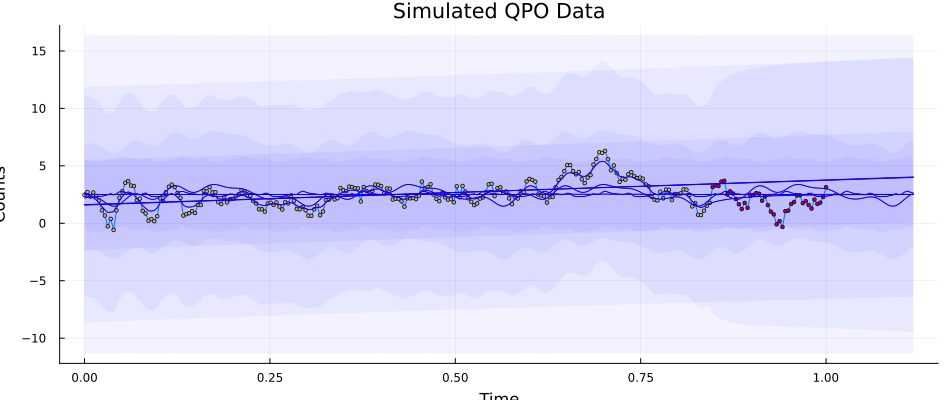

In [52]:
# Creating the Plot for untrained model preditction, just fitting the GP
plot(df.times, df.counts, label = "Toy QPO",  legend = false)
scatter!(df_train.times, df_train.counts, label="Train Data", color="yellow", markersize=2)
scatter!(df_test.times, df_test.counts,label="Test Data", color="red", markersize=2)

for i=1:AutoGP.num_particles(model)
    subdf = forecasts[forecasts.particle.==i,:]
    plot!(subdf[!,"ds"], subdf[!,"y_mean"], color="red", linewidth=.5) #Here ds is times
    l = subdf[!,"y_0.025"]
    u = subdf[!,"y_0.975"]
    plot!(subdf.ds, (l .+ u) ./ 2, ribbon = (l .- u) ./ 2, 
        fillalpha=0.05, color=:blue, label="Filled Area")
end

xlabel!("Time")
ylabel!("Counts")
title!("Simulated QPO Data")
plot!(size=(950, 400))

### Training and Fitting model on Training Data, predicting on Test Data

With only 1 thread and 6 particles, it took 3min, 23.9s

In [53]:
AutoGP.seed!(6)
AutoGP.fit_smc!(model; schedule=AutoGP.Schedule.linear_schedule(n_train, .10), n_mcmc=75, n_hmc=10, verbose=true);

Running SMC round 22/216


┌ Warning: Using more particles than available threads.
└ @ AutoGP /Users/gaurav/.julia/packages/AutoGP/db9sI/src/api.jl:209


Particle Weights: [1.66e-03, 8.23e-01, 2.76e-02, 4.35e-07, 1.48e-01, 4.81e-05]
Particle ESS: 0.2381970848769287
resampled true


accepted MCMC[13/75] HMC[94/101]
accepted MCMC[24/75] HMC[144/159]


accepted MCMC[39/75] HMC[216/239]
accepted MCMC[31/75] HMC[234/246]


accepted MCMC[46/75] HMC[61/106]
accepted MCMC[12/75] HMC[85/90]


Running SMC round 44/216
Particle Weights: [5.33e-01, 2.88e-03, 1.03e-02, 3.22e-03, 4.42e-01, 8.87e-03]
Particle ESS: 0.34768517440835583
resampled true


accepted MCMC[46/75] HMC[9/55]
accepted MCMC[19/75] HMC[87/104]


accepted MCMC[33/75] HMC[1/34]
accepted MCMC[20/75] HMC[80/99]


accepted MCMC[6/75] HMC[13/19]
accepted MCMC[56/75] HMC[5/61]


Running SMC round 66/216
Particle Weights: [7.57e-06, 1.07e-01, 3.37e-01, 3.33e-01, 2.24e-01, 1.46e-06]
Particle ESS: 0.5836949232608326
resampled false


accepted MCMC[13/75] HMC[51/63]
accepted MCMC[22/75] HMC[43/65]


accepted MCMC[17/75] HMC[7/24]
accepted MCMC[23/75] HMC[26/49]


accepted MCMC[23/75] HMC[25/48]
accepted MCMC[44/75] HMC[9/53]


Running SMC round 88/216
Particle Weights: [2.20e-06, 4.02e-01, 1.73e-01, 3.45e-01, 7.99e-02, 5.75e-06]
Particle ESS: 0.5257694318343583
resampled false


accepted MCMC[1/75] HMC[1/2]
accepted MCMC[17/75] HMC[6/23]


accepted MCMC[16/75] HMC[2/18]
accepted MCMC[19/75] HMC[5/24]


accepted MCMC[18/75] HMC[9/27]
accepted MCMC[23/75] HMC[2/25]


Running SMC round 110/216
Particle Weights: [4.94e-07, 4.28e-01, 3.85e-01, 1.55e-01, 3.20e-02, 6.16e-07]
Particle ESS: 0.4678657910351867
resampled true


accepted MCMC[22/75] HMC[8/30]
accepted MCMC[10/75] HMC[4/14]


accepted MCMC[22/75] HMC[4/26]
accepted MCMC[19/75] HMC[5/24]


accepted MCMC[24/75] HMC[10/34]
accepted MCMC[23/75] HMC[4/27]


Running SMC round 132/216
Particle Weights: [4.53e-01, 1.55e-01, 1.44e-01, 1.24e-01, 1.09e-01, 1.55e-02]
Particle ESS: 0.6009533111365103
resampled false


accepted MCMC[16/75] HMC[0/16]
accepted MCMC[20/75] HMC[9/29]


accepted MCMC[17/75] HMC[2/19]
accepted MCMC[19/75] HMC[3/22]


accepted MCMC[16/75] HMC[4/20]
accepted MCMC[23/75] HMC[4/27]


Running SMC round 154/216
Particle Weights: [4.18e-01, 2.13e-01, 1.51e-01, 2.13e-01, 2.77e-04, 4.67e-03]
Particle ESS: 0.5782795304766422
resampled false


accepted MCMC[22/75] HMC[3/25]
accepted MCMC[12/75] HMC[3/15]


accepted MCMC[15/75] HMC[7/22]
accepted MCMC[16/75] HMC[1/17]


accepted MCMC[15/75] HMC[0/15]
accepted MCMC[12/75] HMC[2/14]


Running SMC round 176/216
Particle Weights: [5.35e-01, 1.60e-01, 1.49e-01, 1.54e-01, 4.27e-04, 1.99e-03]
Particle ESS: 0.4658972529535254
resampled true


accepted MCMC[18/75] HMC[4/22]
accepted MCMC[23/75] HMC[9/32]


accepted MCMC[14/75] HMC[0/14]
accepted MCMC[22/75] HMC[5/27]


accepted MCMC[15/75] HMC[6/21]
accepted MCMC[21/75] HMC[1/22]


Running SMC round 198/216
Particle Weights: [2.10e-01, 1.52e-01, 6.57e-02, 1.42e-01, 1.03e-01, 3.27e-01]
Particle ESS: 0.7967245243498345
resampled false


accepted MCMC[19/75] HMC[4/23]
accepted MCMC[14/75] HMC[0/14]


accepted MCMC[24/75] HMC[5/29]
accepted MCMC[20/75] HMC[3/23]


accepted MCMC[9/75] HMC[0/9]
accepted MCMC[19/75] HMC[0/19]


Running SMC round 216/216
Particle Weights: [1.30e-01, 3.45e-02, 5.26e-02, 1.04e-01, 1.42e-01, 5.36e-01]
Particle ESS: 0.4905952362664084


accepted MCMC[14/75] HMC[6/20]
accepted MCMC[15/75] HMC[2/17]


accepted MCMC[29/75] HMC[12/41]
accepted MCMC[19/75] HMC[1/20]


accepted MCMC[16/75] HMC[4/20]
accepted MCMC[28/75] HMC[1/29]


In [54]:
time_int = df.times[2] - df.times[1]
times_future = range(start=df.times[end]+ time_int, step= time_int, length=30)
ds_query = vcat(df_train.times, df_test.times, times_future)
forecasts = AutoGP.predict(model, ds_query; quantiles=[0.025, 0.975])
show(forecasts)

      │ ds          particle  weight    y_0.025    y_0.975   y_mean
──────┼─────────────────────────────────────────────────────────────────
    1 │ 0.0                1  0.130136   1.71949   3.27183    2.49566
    2 │ 0.00392157         1  0.130136   1.87311   3.28385    2.57848
    3 │ 0.00784314         1  0.130136   1.90216   3.30234    2.60225
    4 │ 0.0117647          1  0.130136   1.86147   3.26029    2.56088
    5 │ 0.0156863          1  0.130136   1.61888   3.01309    2.31599
    6 │ 0.0196078          1  0.130136   1.14746   2.53988    1.84367
    7 │ 0.0235294          1  0.130136   0.495044  1.88743    1.19124
    8 │ 0.027451           1  0.130136  -0.159793  1.2323     0.536252
    9 │ 0.0313725          1  0.130136  -0.653361  0.738376   0.0425079
  ⋮   │     ⋮          ⋮         ⋮          ⋮         ⋮          ⋮
 1709 │ 1.0902             6  0.53644   -4.07917   6.85885    1.38984
 1710 │ 1.09412            6  0.53644   -4.13738   6.92884    1.39573
 1711 │ 1.09804    

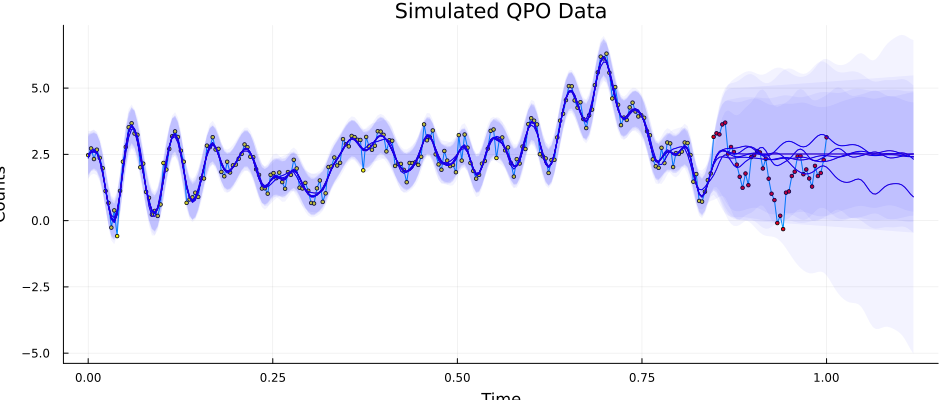

In [55]:
# Creating the Plot for trained model preditction, fitting the GP
plot(df.times, df.counts, label = "Toy QPO",  legend = false)
scatter!(df_train.times, df_train.counts, label="Train Data", color="yellow", markersize=2)
scatter!(df_test.times, df_test.counts,label="Test Data", color="red", markersize=2)

for i=1:AutoGP.num_particles(model)
    subdf = forecasts[forecasts.particle.==i,:]
    plot!(subdf[!,"ds"], subdf[!,"y_mean"], color="red", linewidth=.5) #Here ds is times
    l = subdf[!,"y_0.025"]
    u = subdf[!,"y_0.975"]
    plot!(subdf.ds, (l .+ u) ./ 2, ribbon = (l .- u) ./ 2, 
        fillalpha=0.05, color=:blue, label="Filled Area")
end

xlabel!("Time")
ylabel!("Counts")
title!("Simulated QPO Data")
plot!(size=(950, 400))

In [56]:
weights = AutoGP.particle_weights(model)
kernels = AutoGP.covariance_kernels(model)
for (i, (k, w)) in enumerate(zip(kernels, weights))
    println("Model $(i), Weight $(w)")
    display(k)
end

×
├── ×
│   ├── LIN(0.43; 0.35, 0.03)
│   └── GE(0.24, 1.31; 0.51)
└── PER(0.32, 0.35; 0.22)


×
├── GE(0.22, 1.82; 0.22)
└── ＋
    ├── PER(0.49, 0.39; 0.07)
    └── ×
        ├── GE(0.82, 1.74; 0.09)
        └── PER(1.87, 0.06; 0.62)


×
├── GE(0.21, 1.58; 0.21)
└── ＋
    ├── ×
    │   ├── GE(2.44, 1.34; 0.09)
    │   └── ＋
    │       ├── LIN(0.30; 0.30, 0.14)
    │       └── LIN(0.14; 0.10, 0.06)
    └── PER(0.21, 0.41; 0.09)


Model 1, Weight 0.13013647247039964
Model 2, Weight 0.03451145748973362
Model 3, Weight 0.0525522114847088


×
├── LIN(0.24; 0.27, 0.50)
└── PER(0.05, 1.98; 0.05)


×
├── GE(0.52, 1.18; 0.09)
└── PER(0.13, 0.82; 0.24)


×
├── GE(0.64, 1.89; 0.42)
└── ＋
    ├── PER(0.17, 0.64; 0.06)
    └── LIN(0.40; 0.23, 0.77)


Model 4, Weight 0.10419617486452187
Model 5, Weight 0.14216385759537398
Model 6, Weight 0.5364398260952613


In [57]:
logps = AutoGP.predict_proba(model, df_test.times, df_test.counts);
show(logps)

   │ particle  weight     logp
───┼───────────────────────────────
 1 │        1  0.130136   -29.7665
 2 │        2  0.0345115  -26.7834
 3 │        3  0.0525522  -30.2363
 4 │        4  0.104196   -28.8609
 5 │        5  0.142164   -28.2119
 6 │        6  0.53644    -30.5009

### Plotting the Values of the calculated kernel and comparing with our kernel

Here, we are plotting kernel(x, 0.0), (kernel values as a function of eucledian distance)

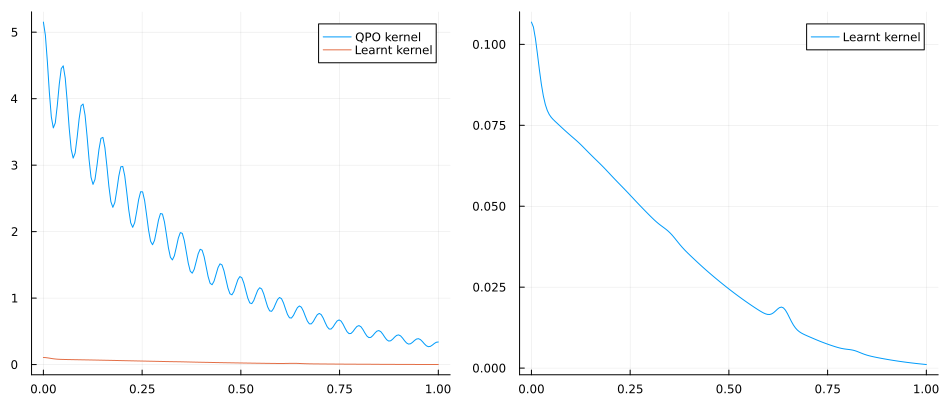

In [143]:
aqpo = exp(-0.4)
cqpo = exp(1)
freqqpo = 20
arn = exp(1.5)
crn = exp(1.0)

function QPO_kernel(x, y)
    t = abs(x - y)
    k = aqpo * exp(-cqpo * t) * cos.(2 * π * freqqpo * t) + arn * exp(-crn * t)
    return k
end

function learnt_kernel(x,y)
    a = 0
    for i = 1:6
        a = a + AutoGP.GP.eval_cov(kernels[i], x, y)*weights[i]
    end
    return a
end

len = 200
x = range(0, stop=1, length=len)
kernel_vals = QPO_kernel.(x[1], x)
learnt_kernel_vals = learnt_kernel.(x[1], x)

plot1 = plot(x, kernel_vals, label="QPO kernel")
plot1 = plot!(x, learnt_kernel_vals, label="Learnt kernel")
plot2 = plot(x, learnt_kernel_vals, label="Learnt kernel")
plot_layout = plot(plot1, plot2, layout=(1, 2))
plot!(size=(950, 400))